<h1> Libraries

In [1]:
# Libraries
import gurobipy as grb
from gurobipy import GRB
import numpy as np
import json
import pandas as pd

<h1> Lecture des instances

In [2]:
read_json = 1
taille = "small"

if taille == "medium":
    path = 'instances/medium_instance.json'
elif taille == "large":
    path = 'instances/large_instance.json'
else:
    path = 'instances/toy_instance.json'


In [3]:
with open(path, 'r') as f:
  inst = json.load(f)

<h3> Employés

In [4]:
employés = np.array(inst["staff"])
print(employés)

[{'name': 'Olivia', 'qualifications': ['A', 'B', 'C'], 'vacations': []}
 {'name': 'Liam', 'qualifications': ['A', 'B'], 'vacations': [1]}
 {'name': 'Emma', 'qualifications': ['C'], 'vacations': [2]}]


<h3> Projets

In [5]:
jobs = np.array(inst["jobs"])
print(jobs)

[{'name': 'Job1', 'gain': 20, 'due_date': 3, 'daily_penalty': 3, 'working_days_per_qualification': {'A': 1, 'B': 1, 'C': 1}}
 {'name': 'Job2', 'gain': 15, 'due_date': 3, 'daily_penalty': 3, 'working_days_per_qualification': {'A': 1, 'B': 2}}
 {'name': 'Job3', 'gain': 15, 'due_date': 4, 'daily_penalty': 3, 'working_days_per_qualification': {'A': 1, 'C': 2}}
 {'name': 'Job4', 'gain': 20, 'due_date': 3, 'daily_penalty': 3, 'working_days_per_qualification': {'B': 2, 'C': 1}}
 {'name': 'Job5', 'gain': 10, 'due_date': 5, 'daily_penalty': 3, 'working_days_per_qualification': {'C': 2}}]


<h3> Compétences

In [6]:
qualifications = np.array(inst["qualifications"])
print(qualifications)

['A' 'B' 'C']


In [7]:
horizon = np.array(inst["horizon"])
print(horizon)

5


<h1> Chargement des instances dans le modèle

In [8]:
m = grb.Model("Model")

Set parameter Username
Academic license - for non-commercial use only - expires 2024-01-20


In [9]:
#Paramètres 
if read_json == 0:
    nb_proj = 3
    nb_pers = 4
    nb_comp = 3
    nb_jour= 12
else:
    nb_proj = len(np.array(inst["jobs"]))
    nb_pers = len(np.array(inst["staff"]))
    nb_comp = len(np.array(inst["qualifications"]))
    nb_jour = np.array(inst["horizon"])

M = 10000 
Jmax = 1000

In [10]:
#Compétences des employés
C = np.zeros((nb_pers, nb_comp))
#Compétences requises pour les projets
P = np.zeros((nb_proj, nb_comp))
P_temp = []
#Congés
V = np.zeros((nb_pers, nb_jour))
#Gain
G = np.zeros(nb_proj)
#Echéance de projet
E = np.zeros(nb_proj)
#Pénalités
L = np.zeros(nb_proj)

<h3> Remplissage de Gain, Echéance et Pénalités

In [11]:
i=0
for j in jobs:
    G[i] = j["gain"]
    E[i] = j["due_date"]
    L[i] = j["daily_penalty"]
    P_temp.append(j["working_days_per_qualification"])
    i+=1

In [12]:
i=0
qual_emp = []
vacances = []
for j in employés:
    qual_emp.append(j["qualifications"])
    vacances.append(j["vacations"])
    i+=1

<h3> Remplissage de Congés

In [13]:
for i in range(nb_pers):
    for j in range(nb_jour):
        if j in vacances[i]:
            V[i][j] = 1

<h3> Remplissage Compétences Employés

In [14]:
for i in range(nb_pers):
    for j in range(nb_comp):
        if chr(65+j) in qual_emp[i]:
            C[i][j] = 1

<h3> Remplissage Compétences Projets

In [15]:
p = 0
for proj in  P_temp : #range(nb_proj)
    for i in range(nb_comp):
        if chr(65+i) in proj:
            P[p][i] = proj[chr(65+i)]
    p+=1

<h3> Affichage des constantes

In [16]:
print("C:",C,"\n\n","P:",P,"\n\n","V:",V,"\n\n","G:",G,"\n\n","E:",E,"\n\n","L:",L)

C: [[1. 1. 1.]
 [1. 1. 0.]
 [0. 0. 1.]] 

 P: [[1. 1. 1.]
 [1. 2. 0.]
 [1. 0. 2.]
 [0. 2. 1.]
 [0. 0. 2.]] 

 V: [[0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]] 

 G: [20. 15. 15. 20. 10.] 

 E: [3. 3. 4. 3. 5.] 

 L: [3. 3. 3. 3. 3.]


<h1> Variables

In [17]:
#Affectation
A = m.addMVar((nb_pers, nb_proj, nb_jour, nb_comp), vtype=GRB.BINARY, name="A")

#Réalisation de projet
R = m.addMVar(nb_proj, vtype=GRB.BINARY, name="R")

#Historique des projets par employé
H = m.addMVar((nb_pers,nb_proj), vtype=GRB.BINARY, name="H")

#Horizon de temps
JD = m.addMVar(nb_proj, vtype=GRB.SEMIINT, name="JD")
JF_exact = m.addMVar(nb_proj, vtype=GRB.SEMIINT, name="JF_exact")
JF_retard = m.addMVar(nb_proj, vtype=GRB.SEMIINT, name="JF_retard")

<h1> Contraintes

In [18]:
### --- 1 - Contraintes de qualification --- ###
#Le projet nécessite la compétence C
m.addConstrs((M*P[p,c] >=  grb.quicksum(A[e,p,j,c] for e in range(nb_pers) for j in range(nb_jour)) for p in range(nb_proj) for c in range(nb_comp) if P[p,c] == 0), name='c_compProjet')

#L'employé possède la compétence C
m.addConstrs((M*C[e,c] >=  grb.quicksum(A[e,p,j,c] for p in range(nb_proj) for j in range(nb_jour)) for e in range(nb_pers) for c in range(nb_comp) if C[e,c] == 0), name='c_compEmploye')

### --- 2 - Contraintes d'affectations quotidienne --- ###
#L'employé est affecté à un seul projet par jour, en dehors de ses jours de congé
m.addConstrs((grb.quicksum(A[e,p,j,c] for p in range(nb_proj) for c in range(nb_comp)) <= ( 1 - V[e,j]) for e in range(nb_pers) for j in range(nb_jour)), name='c_affQuotidienne')

### --- 3 - Contraintes de réalisation --- ###
#Un projet est réalisé si les compétences ont été travaillées le nb de jours nécessaires
m.addConstrs((grb.quicksum(A[e,p,j,c] for j in range(nb_jour) for e in range(nb_pers)) >= R[p]*P[p,c] for p in range(nb_proj) for c in range(nb_comp)), name='c_RealProjet_1')
m.addConstrs(((grb.quicksum(A[e,p,j,c] for j in range(nb_jour) for e in range(nb_pers)) - P[p,c] + 1) <= M*R[p] for p in range(nb_proj) for c in range(nb_comp) if P[p,c] != 0), name='c_RealProjet_2')

#Le jour de fin est postérieur au jour de début
m.addConstrs((JD[p] <= JF_exact[p] for p in range(nb_proj)), name='c_debut_finExacte')
m.addConstrs((JF_exact[p] <= JF_retard[p] for p in range(nb_proj)), name='c_finExacte_finRetard')

#Un projet ne peut pas être travaillé avant le jour de début ou après le jour de fin
m.addConstrs((JD[p] <= j + 1 + M * (1 - grb.quicksum(A[e,p,j,c] for c in range(nb_comp))) for e in range(nb_pers) for p in range(nb_proj) for j in range(nb_jour)), name='c_jourDebut')
m.addConstrs((grb.quicksum(A[e,p,j,c] for c in range(nb_comp)) * ( j + 1 ) <= JF_exact[p] for e in range(nb_pers) for p in range(nb_proj) for j in range(nb_jour) ), name='c_jourFin')
# PS : La somme sur les compétences est entre 0 et 1
# La contrainte sur le jour de fin exact se répercute sur le jour de fin pour le retard

### --- 4 - Contrainte sur l'historique --- ###
#Cohérence affectation et historique 
m.addConstrs((H[e,p] <= grb.quicksum(A[e,p,j,c] for j in range(nb_jour) for c in range(nb_comp))  for e in range(nb_pers) for p in range(nb_proj)), name='c_historique1')
m.addConstrs((grb.quicksum(A[e,p,j,c] for j in range(nb_jour) for c in range(nb_comp)) <= M*H[e,p]  for e in range(nb_pers) for p in range(nb_proj)), name='c_historique2')

{(0, 0): <MConstr () *awaiting model update*>,
 (0, 1): <MConstr () *awaiting model update*>,
 (0, 2): <MConstr () *awaiting model update*>,
 (0, 3): <MConstr () *awaiting model update*>,
 (0, 4): <MConstr () *awaiting model update*>,
 (1, 0): <MConstr () *awaiting model update*>,
 (1, 1): <MConstr () *awaiting model update*>,
 (1, 2): <MConstr () *awaiting model update*>,
 (1, 3): <MConstr () *awaiting model update*>,
 (1, 4): <MConstr () *awaiting model update*>,
 (2, 0): <MConstr () *awaiting model update*>,
 (2, 1): <MConstr () *awaiting model update*>,
 (2, 2): <MConstr () *awaiting model update*>,
 (2, 3): <MConstr () *awaiting model update*>,
 (2, 4): <MConstr () *awaiting model update*>}

<h1> Fonctions de Coût

<h3> Gain

In [19]:
#Fonction de cout : Maximisation du gain
L1 = grb.quicksum(G[p] * R[p] - L[p] * (JF_retard[p] - E[p] ) for p in range(nb_proj)) 

m.addConstrs((JF_retard[p] >= E[p] for p in range(nb_proj)), name='c_L1_1')
m.addConstrs((JF_retard[p] <= E[p] + M * R[p] for p in range(nb_proj)), name='c_L1_2')

{0: <MConstr () *awaiting model update*>,
 1: <MConstr () *awaiting model update*>,
 2: <MConstr () *awaiting model update*>,
 3: <MConstr () *awaiting model update*>,
 4: <MConstr () *awaiting model update*>}

<h3> Projets par Employés

In [20]:
#Fonction de cout : Minimisation du nombre de projet par employés
Z2 = m.addVar(vtype=GRB.INTEGER, name="Z2")
m.addConstrs((grb.quicksum(H[e,p] for p in range(nb_proj)) <= Z2 for e in range(nb_pers)), name='c_z2')

{0: <MConstr () *awaiting model update*>,
 1: <MConstr () *awaiting model update*>,
 2: <MConstr () *awaiting model update*>}

<h3> Jours consécutifs par Projet

In [21]:
#Fonction de cout : Minimisation du nombre de jours par projet
Z3 = m.addVar(vtype=GRB.INTEGER, name="Z3")
m.addConstrs((JF_exact[p] - JD[p] + 1 <= Z3 for p in range(nb_proj)), name='c_z3')

{0: <MConstr () *awaiting model update*>,
 1: <MConstr () *awaiting model update*>,
 2: <MConstr () *awaiting model update*>,
 3: <MConstr () *awaiting model update*>,
 4: <MConstr () *awaiting model update*>}

<h1> Objectifs

In [22]:
m.setObjective(L1, GRB.MAXIMIZE)

In [23]:
m.setParam("OutputFlag", 0)

<h1> Résolution

In [24]:
# Update model
m.update()

In [25]:
def resolve(m, obj2_epsilon, obj3_epsilon):
    Cobj_2 = m.addConstr(Z2 <= obj2_epsilon, name='c_obj_2')
    Cobj_3 = m.addConstr(Z3 <= obj3_epsilon, name='c_obj_3')
    m.update()
    #m.printStats()
    m.optimize()
    print("Modèle avec eps2="+str(obj2_epsilon)+" et eps3="+str(obj3_epsilon), "\n")
    print("Optimalité :", m.Status == GRB.OPTIMAL,"( status", m.Status,")")
    print("Obj1 :", m.ObjVal)
    print("Obj2 :", Z2.X)
    print("Obj3 :", Z3.X)
    print()
    Vars = {}
    for var in m.getVars():
        Vars[var.varname] = var.X
    res = Vars, m.ObjVal, Z2.X, Z3.X
    m.remove(Cobj_2)
    m.remove(Cobj_3)
    m.update()
    return res


In [26]:
Vars, l1, z2, z3 = resolve(m, 5, 11)
print()

Modèle avec eps2=5 et eps3=11 

Optimalité : True ( status 2 )
Obj1 : 65.0
Obj2 : 5.0
Obj3 : 11.0




<h1> Affichage

In [27]:
def getValfromVars(Vars, v_name, *args):
    key = v_name
    if len(args) > 0:
        key += "[" + str(args[0])
        for arg in args[1:]:
            key += "," + str(arg)
        key += "]"
    try:
        return Vars[key]
    except:
        print("La clef formée (" + key + ") n'est pas dans le dictionnaire des variables")
        return None

In [28]:
def affichage(Vars):
    for e in range(nb_pers):
        nom_employe = employés[e]["name"]
        to_print = "Employé " + nom_employe + " :    \t| "
        for j in range(nb_jour):
            conge = True
            for p in range(nb_proj):
                nom_projet = jobs[p]["name"]
                for c in range(nb_comp):
                    nom_competence = qualifications[c]
                    if getValfromVars(Vars, "A", e, p, j, c):
                        to_print += nom_projet + " - " + nom_competence + " | "
                        conge = False
            if conge and V[e,j]:
                to_print += "cong - x | "
            elif conge:
                to_print += "---- - - | "

        to_print += "\n"
        print(to_print)

<h1> Résultats

In [29]:
def getNDSol(m, eps2_max, eps3_max):
    Res = []
    Sols = {}
    Objectives = np.zeros((eps2_max+1,eps3_max))
    for eps2 in range(eps2_max+1):
        for eps3 in range(1,eps3_max+1):
            Vars, l1, z2, z3 = resolve(m, eps2, eps3)
            Res.append([l1,z2,z3])
            Objectives[eps2,eps3-1] = l1
            Sols[(eps2,eps3)] = Vars
            affichage(Vars)
    return Res, Sols, Objectives

In [50]:
nb_projet_max = 5
nb_jours_consecutif_max = 5
Res, Sols, Objectives = getNDSol(m, nb_projet_max, nb_jours_consecutif_max)

Modèle avec eps2=0 et eps3=1 

Optimalité : True ( status 2 )
Obj1 : -0.0
Obj2 : 0.0
Obj3 : 1.0

Employé Olivia :    	| ---- - - | ---- - - | ---- - - | ---- - - | ---- - - | 

Employé Liam :    	| ---- - - | cong - x | ---- - - | ---- - - | ---- - - | 

Employé Emma :    	| ---- - - | ---- - - | cong - x | ---- - - | ---- - - | 

Modèle avec eps2=0 et eps3=2 

Optimalité : True ( status 2 )
Obj1 : -0.0
Obj2 : 0.0
Obj3 : 2.0

Employé Olivia :    	| ---- - - | ---- - - | ---- - - | ---- - - | ---- - - | 

Employé Liam :    	| ---- - - | cong - x | ---- - - | ---- - - | ---- - - | 

Employé Emma :    	| ---- - - | ---- - - | cong - x | ---- - - | ---- - - | 

Modèle avec eps2=0 et eps3=3 

Optimalité : True ( status 2 )
Obj1 : -0.0
Obj2 : 0.0
Obj3 : 3.0

Employé Olivia :    	| ---- - - | ---- - - | ---- - - | ---- - - | ---- - - | 

Employé Liam :    	| ---- - - | cong - x | ---- - - | ---- - - | ---- - - | 

Employé Emma :    	| ---- - - | ---- - - | cong - x | ---- - - | ---- - - | 

M

In [51]:
def afficherEtSauverPlanning(solution):
    planning_df = pd.DataFrame()
    planning = np.zeros(nb_pers)
    plan_series_list = []

    for e in range(nb_pers):
        nom_employe = employés[e]["name"]
        plan = [nom_employe]
        for j in range(nb_jour):
            conge = True
            for p in range(nb_proj):
                nom_projet = jobs[p]["name"]
                for c in range(nb_comp):
                    nom_competence = qualifications[c]
                    if getValfromVars(solution, "A", e, p, j, c):
                        plan.append(nom_projet + " - " + nom_competence)
                        conge=False
            if conge and V[e,j]:
                plan.append("Congé")
            elif conge:
                plan.append(" ") 
        # print(plan)
        plan_series_list.append(pd.Series(plan))
    
    planning_df = pd.concat(plan_series_list, ignore_index=True, axis=1).T
    print(planning_df)
        
    if taille == "medium":
        pd.DataFrame(planning_df).to_excel("output/planning_medium.xlsx")
    elif taille == "large":
        pd.DataFrame(planning_df).to_excel("output/planning_large.xlsx")
    else:
        pd.DataFrame(planning_df).to_excel("output/planning_small.xlsx")



In [52]:
afficherEtSauverPlanning(list(Sols.values())[-1])

        0         1         2         3         4         5
0  Olivia  Job4 - B  Job1 - B  Job2 - B  Job3 - C  Job5 - C
1    Liam  Job4 - B     Congé  Job1 - A  Job3 - A          
2    Emma  Job4 - C  Job1 - C     Congé  Job3 - C  Job5 - C


## Affichage des objectifs

In [53]:
print(Objectives)

[[-0. -0. -0. -0. -0.]
 [20. 30. 40. 42. 42.]
 [37. 50. 65. 65. 65.]
 [49. 65. 65. 65. 65.]
 [59. 65. 65. 65. 65.]
 [59. 65. 65. 65. 65.]]


In [54]:
Projets = np.arange(nb_projet_max+1)
Jours = np.arange(nb_jours_consecutif_max)+1
print(Jours)
print(Projets)

[1 2 3 4 5]
[0 1 2 3 4 5]


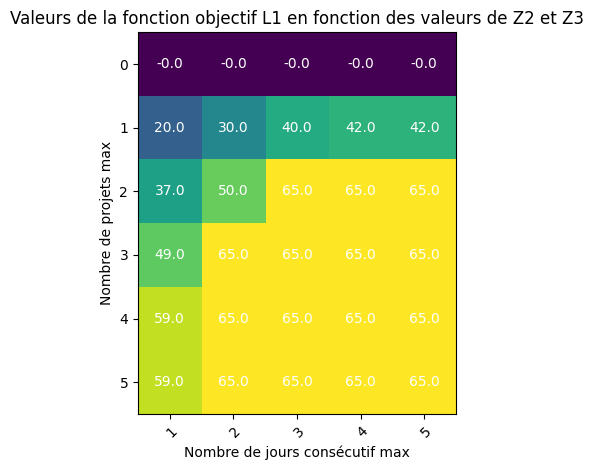

In [55]:
import matplotlib
import matplotlib as mpl
import matplotlib.pyplot as plt


fig, ax = plt.subplots()
im = ax.imshow(Objectives)

# Show all ticks and label them with the respective list entries
ax.set_xticks(np.arange(len(Jours)), labels=Jours)
ax.set_yticks(np.arange(len(Projets)), labels=Projets)
ax.set_xlabel("Nombre de jours consécutif max")
ax.set_ylabel("Nombre de projets max")

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

# Loop over data dimensions and create text annotations.
for i in range(len(Projets)):
    for j in range(len(Jours)):
        text = ax.text(j, i, Objectives[i, j],
                       ha="center", va="center", color="w")

ax.set_title("Valeurs de la fonction objectif L1 en fonction des valeurs de Z2 et Z3")
fig.tight_layout()
plt.show()